# DSI Capstone
## Predicting Hospital Survey Results

My goal for the capstone is to use Medicare payment and quality data to predict hospital survey results. I will use the facility's quality metrics and a mix of dollar spent per patient/claim as well as dollars hospitals receive from outside e.g. Research Grants, paid lunches, ect. 

Data for non patient care expenses will be taken from https://www.cms.gov/OpenPayments/index.html

Data for Patient Surveys and Hospital spend on care will be taken from 
https://data.medicare.gov/

This research will determine if patient perception of care is impacted by dollars spent on care or other incoming funds incoming to the hospital. 

In [11]:
#!pip install pymysql

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
from pandas.io import sql
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [32]:
host="cms.ctvgwsug2thu.us-west-1.rds.amazonaws.com"
port=3306
dbname="cms"
user="bassrocker400"
password="}7n^:EU6DJs:iWN__3Ku"

conn = pymysql.connect(host, user=user,port=port,
                           passwd=password, db=dbname)

In [13]:
# quality_fac = pd.read_sql('select * from QualityMeasures_Facility;', con=conn) 

# quality_fac.head()

,Provider_Number,Hospital_Name,Address,City,State,ZIP_Code,County_Name,HBIPS-2_Measure_Description,HBIPS-2_Overall_Rate_Per_1000,HBIPS-2_Overall_Num,...,IMM-2_Denominator,IMM-2_Footnote,HCP_Measure_Description,HCP_%,HCP_Numerator,HCP_Denominator,HCP_Footnote,Flu_Season_Start_Date,Flu_Season_End_Date,ID
0,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN STREET PO BOX 1010,OPP,AL,36467,Covington,Hours of physical-restraint use,Not Available,0,...,Not Available,1,Healthcare Personnel Influenza Vaccination,41%,13,32,,10/01/2016,03/31/2017,1
1,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,Crenshaw,Hours of physical-restraint use,0.09,12.15,...,290,,Healthcare Personnel Influenza Vaccination,60%,31,52,,10/01/2016,03/31/2017,2
2,010011,ST. VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,Jefferson,Hours of physical-restraint use,0.00,0,...,165,,Healthcare Personnel Influenza Vaccination,60%,106,176,,10/01/2016,03/31/2017,3
3,010012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DeKalb,Hours of physical-restraint use,0.00,0,...,88,,Healthcare Personnel Influenza Vaccination,100%,43,43,,10/01/2016,03/31/2017,4
4,010016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,Shelby,Hours of physical-restraint use,0.03,12.47,...,317,,Healthcare Personnel Influenza Vaccination,96%,81,84,,10/01/2016,03/31/2017,5


In [4]:
# quality_fac.columns

Index(['Provider_Number', 'Hospital_Name', 'Address', 'City', 'State',
       'ZIP_Code', 'County_Name', 'HBIPS-2_Measure_Description',
       'HBIPS-2_Overall_Rate_Per_1000', 'HBIPS-2_Overall_Num',
       'HBIPS-2_Overall_Den', 'HBIPS-2_Overall_Footnote',
       'HBIPS-3_Measure_Description', 'HBIPS-3_Overall_Rate_Per_1000',
       'HBIPS-3_Overall_Num', 'HBIPS-3_Overall_Den',
       'HBIPS-3_Overall_Footnote', 'HBIPS-5_Measure_Description',
       'HBIPS-5_Overall_%_of_Total', 'HBIPS-5_Overall_Num',
       'HBIPS-5_Overall_Den', 'HBIPS-5_Overall_Footnote',
       'SUB-1_Measure_Description', 'SUB-1_%', 'SUB-1_Numerator',
       'SUB-1_Denominator', 'SUB-1_Footnote', 'SUB-2/-2a_Measure_Description',
       'SUB-2_%', 'SUB-2_Numerator', 'SUB-2_Denominator', 'SUB-2_Footnote',
       'SUB-2a_%', 'SUB-2a_Numerator', 'SUB-2a_Denominator', 'SUB-2a_Footnote',
       'TOB-1_Measure_Description', 'TOB-1_%', 'TOB-1_Numerator',
       'TOB-1_Denominator', 'TOB-1_Footnote', 'TOB-2/-2a_Measure_Des

In [15]:
te_care = pd.read_sql('select * from timeandeff;', con = conn)
te_care.head()


,Provider_ID,Hospital_Name,Address,City,State,ZIP Code,County Name,Phone Number,Condition,Measure_ID,Measure_Name,Score,Sample,Footnote,Measure_Start_Date,Measure_End_Date,ID
0,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_1b,ED1,237,583,2 - Data submitted were based on a sample of c...,10/01/2016,09/30/2017,262141
1,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_2b,ED2,74,583,2 - Data submitted were based on a sample of c...,10/01/2016,09/30/2017,262142
2,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,EDV,Emergency department volume,"High (40,000 - 59,999 patients annually)",,,01/01/2016,12/31/2016,262143
3,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Preventive Care,IMM_2,Immunization for influenza,92,552,2 - Data submitted were based on a sample of c...,10/01/2016,03/31/2017,262144
4,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Preventive Care,IMM_3_OP_27_FAC_ADHPCT,Healthcare workers given influenza vaccination,86,4457,,10/01/2016,03/31/2017,262145


In [31]:
te_care.query("Measure_ID == 'EDV'")

,Provider_ID,Hospital_Name,Address,City,State,ZIP Code,County Name,Phone Number,Condition,Measure_ID,Measure_Name,Score,Sample,Footnote,Measure_Start_Date,Measure_End_Date,ID
2,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,EDV,Emergency department volume,"High (40,000 - 59,999 patients annually)",,,01/01/2016,12/31/2016,262143
25,010005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Emergency Department,EDV,Emergency department volume,"Very High (60,000+ patients annually)",,,01/01/2016,12/31/2016,262166
48,010006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Emergency Department,EDV,Emergency department volume,"High (40,000 - 59,999 patients annually)",,,01/01/2016,12/31/2016,262189
71,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Emergency Department,EDV,Emergency department volume,"Low (0 - 19,999 patients annually)",,,01/01/2016,12/31/2016,262212
94,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Emergency Department,EDV,Emergency department volume,"Low (0 - 19,999 patients annually)",,,01/01/2016,12/31/2016,262235
117,010011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,Emergency Department,EDV,Emergency department volume,"High (40,000 - 59,999 patients annually)",,,01/01/2016,12/31/2016,262258
140,010012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Emergency Department,EDV,Emergency department volume,"Medium (20,000 - 39,999 patients annually)",,,01/01/2016,12/31/2016,262281
163,010016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,Emergency Department,EDV,Emergency department volume,"High (40,000 - 59,999 patients annually)",,,01/01/2016,12/31/2016,262304
186,010018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Emergency Department,EDV,Emergency department volume,"Low (0 - 19,999 patients annually)",,,01/01/2016,12/31/2016,262327
209,010019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,Emergency Department,EDV,Emergency department volume,"High (40,000 - 59,999 patients annually)",,,01/01/2016,12/31/2016,262350


In [36]:
te_care['Score'] = te_care['Score'].replace('Very High (60,000+ patients annually)', 4)
te_care['Score'] = te_care['Score'].replace('High (40,000 - 59,999 patients annually)', 3)
te_care['Score'] = te_care['Score'].replace('Medium (20,000 - 39,999 patients annually)', 2)
te_care['Score'] = te_care['Score'].replace('Low (0 - 19,999 patients annually)', 1)

In [50]:
te_care['Score'].replace('Not Available',np.NaN, inplace = True)
te_care['Score'].dropna(inplace = True)

In [53]:
te_care['Score'] = te_care['Score'].astype(float)
te_care.dtypes

Provider_ID            object
Hospital_Name          object
Address                object
City                   object
State                  object
ZIP Code               object
County Name            object
Phone Number           object
Condition              object
Measure_ID             object
Measure_Name           object
Score                 float64
Sample                 object
Footnote               object
Measure_Start_Date     object
Measure_End_Date       object
ID                      int64
dtype: object

In [64]:
te_emergency = pd.read_sql('SELECT * from timeandeff \
                            WHERE `Condition` = "Emergency Department"',
                           con = conn)
te_emergency.head()

,Provider_ID,Hospital_Name,Address,City,State,ZIP Code,County Name,Phone Number,Condition,Measure_ID,Measure_Name,Score,Sample,Footnote,Measure_Start_Date,Measure_End_Date,ID
0,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_1b,ED1,237,583,2 - Data submitted were based on a sample of c...,10/01/2016,09/30/2017,262141
1,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,ED_2b,ED2,74,583,2 - Data submitted were based on a sample of c...,10/01/2016,09/30/2017,262142
2,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,EDV,Emergency department volume,"High (40,000 - 59,999 patients annually)",,,01/01/2016,12/31/2016,262143
3,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,OP_18b,OP 18,163,366,,10/01/2016,09/30/2017,262147
4,010001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Emergency Department,OP_18c,OP-18,Not Available,Not Available,1 - The number of cases/patients is too few to...,10/01/2016,09/30/2017,262148


In [65]:
te_emergency['Score'] = te_care['Score'].replace('Very High (60,000+ patients annually)', 4)
te_emergency['Score'] = te_care['Score'].replace('High (40,000 - 59,999 patients annually)', 3)
te_emergency['Score'] = te_care['Score'].replace('Medium (20,000 - 39,999 patients annually)', 2)
te_emergency['Score'] = te_care['Score'].replace('Low (0 - 19,999 patients annually)', 1)

In [66]:
te_emergency['Score'].replace('Not Available',np.NaN, inplace = True)
te_emergency['Score'].dropna(inplace = True)

In [67]:
te_emergency['Score'] = te_emergency['Score'].astype(float)
te_emergency.dtypes

Provider_ID            object
Hospital_Name          object
Address                object
City                   object
State                  object
ZIP Code               object
County Name            object
Phone Number           object
Condition              object
Measure_ID             object
Measure_Name           object
Score                 float64
Sample                 object
Footnote               object
Measure_Start_Date     object
Measure_End_Date       object
ID                      int64
dtype: object

In [72]:
te_emergency = pd.pivot_table(te_emergency, values = 'Score', index = ['Provider_ID','ZIP Code'], columns = 'Measure_ID').reset_index()


In [73]:
te_emergency.head()

Measure_ID,Provider_ID,ZIP Code,EDV,ED_1b,ED_2b,OP_18b,OP_18c,OP_20,OP_21,OP_22,OP_23
0,010001,36301,3.0,237.0,74.0,92.0,86.0,NaN,163.0,NaN,NaN
1,010005,35957,6.0,32.0,70.0,NaN,47.0,92.0,NaN,NaN,NaN
2,010006,35631,3.0,NaN,NaN,62.0,0.0,246.0,77.0,4.0,98.0
3,010007,36467,114.0,80.0,NaN,194.0,NaN,21.0,66.0,2.0,86.0
4,010008,36049,NaN,79.0,97.0,100.0,NaN,99.0,15.0,2.0,67.0


In [118]:
# getting it working need better 
te_emergency.fillna(0, inplace = True)

In [104]:
pat_star = pd.read_sql('SELECT `Provider ID`,`ZIP Code`,`Patient Survey Star Rating` from hospital_survey \
WHERE `HCAHPS Measure ID` = "H_STAR_RATING" AND `Patient Survey Star Rating` <> "Not Available";',con = conn)
                                

survey_hospital.head()

,Provider ID,ZIP Code,Patient Survey Star Rating
0,010001,36301,2
1,010005,35957,3
2,010006,35631,3
3,010007,36467,3
4,010011,35235,3


In [105]:
pat_star['Patient Survey Star Rating'] = survey_hospital['Patient Survey Star Rating'].astype(int)


In [106]:
pat_star.dtypes

Provider ID                   object
ZIP Code                      object
Patient Survey Star Rating     int64
dtype: object

In [107]:
pat_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3462 entries, 0 to 3461
Data columns (total 3 columns):
Provider ID                   3462 non-null object
ZIP Code                      3462 non-null object
Patient Survey Star Rating    3462 non-null int64
dtypes: int64(1), object(2)
memory usage: 81.2+ KB


In [109]:
pat_star['Patient Survey Star Rating'].value_counts()

3    1557
4    1116
2     508
5     212
1      69
Name: Patient Survey Star Rating, dtype: int64

(array([  69.,  508., 1557., 1116.,  212.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

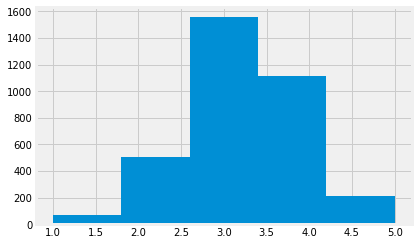

In [15]:
plt.hist(pat_star['Patient Survey Star Rating'].astype(int), bins = 5)

In [135]:
spend_pat = pd.read_sql('select `Provider ID`,`ZIP Code`,`Score` as Spend_Score from patient_spend_fac where Score <> "Not Available";', con=conn)
spend_pat.head()

DatabaseError: Execution failed on sql: select `Provider ID`,`ZIP Code`,`Score` as Spend_Score from patient_spend_fac where Score <> "Not Available";
(2013, 'Lost connection to MySQL server during query ([Errno 54] Connection reset by peer)')
unable to rollback

In [125]:
spend_pat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 3 columns):
Provider ID    1561 non-null object
ZIP Code       1561 non-null object
Spend_Score    1561 non-null object
dtypes: object(3)
memory usage: 36.7+ KB


In [126]:
spend_pat['Spend_Score'] = spend_pat['Spend_Score'].astype(float)

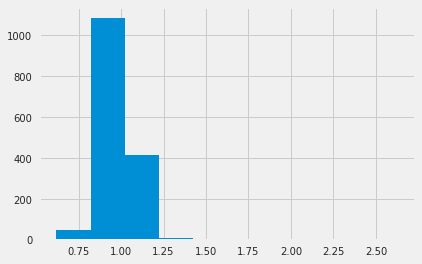

In [127]:
spend_pat['Spend_Score'].hist()

# MSPB Calculation
- ### Properties

Description The Medicare Spending Per Beneficiary (MSPB) Measure evaluates solo
practitioners and
groups of practitioners (including physicians) on their efficiency and is
specialty-adjusted to
account for the group’s specialty mix. Solo practitioners and groups of
practitioners (including
physicians) are identified by their Taxpayer Identification Number (TIN).
Specifically, the
MSPB Measure assesses the cost to Medicare of services performed by TINs
during an MSPB
episode, which comprises the period immediately prior to, 
during, and following
a patient’s
hospital stay
- ### Numerator

The numerator for a TIN s specialty-adjusted MSPB Measure is the TIN s
average MSPB Amount, which is defined as the sum of standardized, riskadjusted
spending across all of a TIN s eligible episodes divided by the
number of episodes for that TIN. This ratio is multiplied by the national average
standardized episode cost. An MSPB episode includes all Medicare Part A and
Part B claims with a start date falling between 3 days prior to an Inpatient
Prospective Payment System (IPPS) hospital admission (also known as the
index admission for the episode) through 30 days post-hospital discharge.
- ### Denominator

The denominator for a TIN s MSPB Measure is the specialty-adjusted MSPB
expected cost based on the national specialty-specific expected cost of the
specialties represented by the TIN s eligible professionals (EPs). Methodology
for specialty-adjustment is discussed in the Specialty adjustment sectionbelow. Beneficiary populations eligible to be included in the MSPB Measure
are made up of beneficiaries who were enrolled in both Medicare Parts A and
B for the period 93 days prior to IPPS hospital admission until 30 days after
discharge from a short-term acute care hospital stay, where the stay occurs
during the period of performance. Defining the population in this manner
ensures that each beneficiary s claims record contains sufficient fee-for-service
(FFS) data both for measuring spending levels and for risk adjustment
purposes. Only claims for beneficiaries admitted to subsection (d) hospitals
during the period of performance are included in the calculation of the MSPB
Measure. Subsection (d) hospitals are hospitals in the 50 States and D.C.
other than: psychiatric hospitals, rehabilitation hospitals, hospitals whose
inpatients are predominantly under 18 years old, hospitals whose average
inpatient length of stay exceeds 25 days, and hospitals involved extensively in
treatment for or research on cancer. The claims for inpatient admissions to
subsection (d) hospitals are grouped into stays by beneficiary, admission date,
and provider.

- ### Denominator Exclusions

Beneficiary populations excluded from the MSPB calculation are those with
episodes where
at any time 93 days before admission through 30 days post-discharge, the
beneficiary is enrolled
in a Medicare Advantage plan, or Medicare is the secondary payer. Episodes
where the
beneficiary becomes deceased during the episode are also excluded.
Regarding beneficiaries
whose primary insurance becomes Medicaid during an episode due to
exhaustion of Medicare
Part A benefits, Medicaid payments made for services rendered to these
beneficiaries are
excluded, however, all Medicare Part A payments made before benefits are
exhausted and all
Medicare Part B payments made during the episode are included.
Further, any episode in which the index admission inpatient claim has a 0
actual payment or a 0 standardized payment is excluded. In addition, acute-to-acute transfers
(where a transfer
is defined based on the claim discharge code) are not considered index
admissions. In other words, these cases do not generate new MSPB episodes, neither the hospital
which transfers a
patient to another subsection (d) hospital, nor the receiving subsection (d)
hospital will have an
index admission or associated MSPB episode attributed to them.
Admissions to hospitals that Medicare does not reimburse through the IPPS
system (e.g.,
cancer hospitals, critical access hospitals, hospitals in Maryland) are not
considered index
admissions and are therefore not eligible to begin an MSPB episode. If an
acute-to-acute
hospital transfer or a hospitalization in a PPS-exempt hospital happens during
the 30-days
following discharge from an index admission, however, these post-discharge
costs will count
toward in the measure.

https://cmit.cms.gov/CMIT_public/ViewMeasure?MeasureId=1643

In [ ]:
 emergency = te_emergency.join(spend_pat)

In [131]:
te_emergency.columns

Index(['Provider_ID', 'ZIP Code', 'EDV', 'ED_1b', 'ED_2b', 'OP_18b', 'OP_18c',
       'OP_20', 'OP_21', 'OP_22', 'OP_23'],
      dtype='object', name='Measure_ID')

In [134]:
pat_star.columns

Index(['Provider_ID', 'ZIP Code', 'Patient Survey Star Rating'], dtype='object')

In [136]:
spend_pat.columns

Index(['Provider ID', 'ZIP Code', 'Spend_Score'], dtype='object')

In [138]:
te_emergency.set_index('Provider_ID', inplace = True)
pat_star.set_index('Provider_ID',inplace = True)
spend_pat.set_index('Provider ID',inplace = True)

In [140]:
emergency = pat_star.join(te_emergency, lsuffix='_pat_star', rsuffix='_te_emergency')

,ZIP Code_pat_star,Patient Survey Star Rating,ZIP Code_te_emergency,EDV,ED_1b,ED_2b,OP_18b,OP_18c,OP_20,OP_21,OP_22,OP_23
Provider_ID,,,,,,,,,,,,
010001,36301,2,36301,3.0,237.0,74.0,92.0,86.0,0.0,163.0,0.0,0.0
010005,35957,3,35957,6.0,32.0,70.0,0.0,47.0,92.0,0.0,0.0,0.0
010006,35631,3,35631,3.0,0.0,0.0,62.0,0.0,246.0,77.0,4.0,98.0
010007,36467,3,36467,114.0,80.0,0.0,194.0,0.0,21.0,66.0,2.0,86.0
010011,35235,3,35235,68.0,0.0,224.0,3.0,99.0,89.0,0.0,144.0,0.0


In [142]:
emergency = emergency.join(spend_pat, lsuffix='_emergency', rsuffix='_spend_pat') 

In [143]:
emergency.head()

,ZIP Code_pat_star,Patient Survey Star Rating,ZIP Code_te_emergency,EDV,ED_1b,ED_2b,OP_18b,OP_18c,OP_20,OP_21,OP_22,OP_23,ZIP Code,Spend_Score
Provider_ID,,,,,,,,,,,,,,
010001,36301,2,36301,3.0,237.0,74.0,92.0,86.0,0.0,163.0,0.0,0.0,36301,0.99
010005,35957,3,35957,6.0,32.0,70.0,0.0,47.0,92.0,0.0,0.0,0.0,NaN,NaN
010006,35631,3,35631,3.0,0.0,0.0,62.0,0.0,246.0,77.0,4.0,98.0,35631,1.00
010007,36467,3,36467,114.0,80.0,0.0,194.0,0.0,21.0,66.0,2.0,86.0,NaN,NaN
010011,35235,3,35235,68.0,0.0,224.0,3.0,99.0,89.0,0.0,144.0,0.0,NaN,NaN


In [146]:
emergency.fillna(0, inplace = True)

In [167]:
emergency.shape

(3462, 14)

In [147]:
emergency.columns

Index(['ZIP Code_pat_star', 'Patient Survey Star Rating',
       'ZIP Code_te_emergency', 'EDV', 'ED_1b', 'ED_2b', 'OP_18b', 'OP_18c',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'ZIP Code', 'Spend_Score'],
      dtype='object')

In [157]:
logreg = LogisticRegression()
ss = StandardScaler()

X = emergency[['EDV', 'ED_1b', 'ED_2b', 'OP_18b', 'OP_18c',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'Spend_Score']]
y = emergency['Patient Survey Star Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [158]:
X_train.shape, y_train.shape

((2596, 10), (2596,))

In [155]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [159]:
model = logreg.fit(X_train_scaled,y_train)

In [165]:
logreg.score(X_train_scaled,y_train)

0.45107858243451465

In [166]:
logreg.score(X_test_scaled,y_test)

0.44341801385681295

In [162]:
preds = model.predict(X_test_scaled)

Text(0.5, 1.0, 'Logistic Regression Coefficients')

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


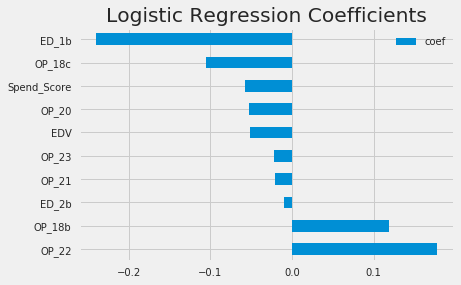

In [168]:
coefs = pd.DataFrame(logreg.coef_[0], index = X.columns, columns = ['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head(20).plot(kind = 'barh')
plt.title('Logistic Regression Coefficients')

# 4 year data


In [4]:
survey = pd.read_sql(
'''SELECT h.`Provider ID`, h.`ZIP Code`, h.year, h.`Patient Survey Star Rating` ,p.`Score` as spend_score  
FROM hospital_survey as h  
LEFT JOIN pat_spend as p on h.`Provider ID` = p.`Provider ID` and h.year = p.year  
WHERE h.`HCAHPS Measure ID` = "H_STAR_RATING" 
AND h.`Patient Survey Star Rating` <> "Not Available" 
GROUP BY 1,2,3;''', con = conn)

In [88]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13988 entries, 0 to 13987
Data columns (total 5 columns):
Provider ID                   13988 non-null object
ZIP Code                      13988 non-null object
year                          13988 non-null int64
Patient Survey Star Rating    13988 non-null int64
spend_score                   11943 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 546.5+ KB


In [89]:
survey.replace("Not Available", np.NaN, inplace = True)
survey['Patient Survey Star Rating'] = survey['Patient Survey Star Rating'].astype(int)
survey['spend_score'] = survey['spend_score'].astype(float)

(array([ 254., 2283., 5871., 4835.,  745.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

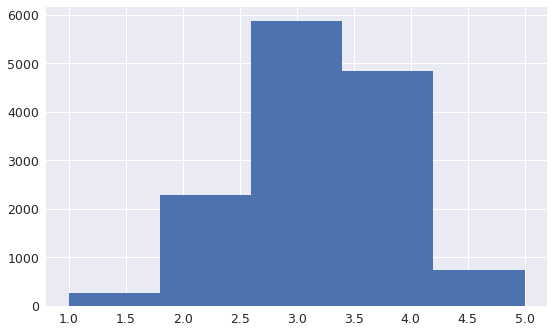

In [90]:
plt.hist(survey['Patient Survey Star Rating'],bins = 5)

In [35]:
te_score = pd.read_sql('''
SELECT Provider_ID, `ZIP Code`, year, Measure_ID, Score as te_score from timeandeff
where Score <> "Not Available"
and year <> 2015
''', con = conn)
te_score.head()

,Provider_ID,ZIP Code,year,Measure_ID,te_score
0,010001,36301,2018,ED_1b,237
1,010001,36301,2018,ED_2b,74
2,010001,36301,2018,EDV,"High (40,000 - 59,999 patients annually)"
3,010001,36301,2018,IMM_2,92
4,010001,36301,2018,IMM_3_OP_27_FAC_ADHPCT,86


In [36]:
te_score['te_score'] = te_score['te_score'].replace('Very High (60,000+ patients annually)', 4)
te_score['te_score'] = te_score['te_score'].replace('High (40,000 - 59,999 patients annually)', 3)
te_score['te_score'] = te_score['te_score'].replace('Medium (20,000 - 39,999 patients annually)', 2)
te_score['te_score'] = te_score['te_score'].replace('Low (0 - 19,999 patients annually)', 1)

In [58]:
te_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13370 entries, 0 to 13369
Data columns (total 28 columns):
Provider_ID               13370 non-null object
ZIP Code                  13370 non-null object
year                      13370 non-null int64
EDV                       10502 non-null float64
ED_1b                     11234 non-null float64
ED_2b                     11185 non-null float64
IMM_2                     12272 non-null float64
IMM_3_OP_27_FAC_ADHPCT    12497 non-null float64
OP_1                      253 non-null float64
OP_18b                    11223 non-null float64
OP_18c                    2781 non-null float64
OP_2                      253 non-null float64
OP_20                     11242 non-null float64
OP_21                     10550 non-null float64
OP_22                     10495 non-null float64
OP_23                     4156 non-null float64
OP_29                     8486 non-null float64
OP_30                     8259 non-null float64
OP_31                

In [37]:
te_score['te_score'] = te_score['te_score'].astype(float)

In [38]:
te_score = pd.pivot_table(te_score, values = 'te_score', index = ['Provider_ID','ZIP Code','year'], columns = 'Measure_ID').reset_index()
te_score.head()

Measure_ID,Provider_ID,ZIP Code,year,EDV,ED_1b,ED_2b,IMM_2,IMM_3_OP_27_FAC_ADHPCT,OP_1,OP_18b,...,OP_31,OP_33,OP_3b,OP_4,OP_5,PC_01,SEP_1,STK_4,VTE_5,VTE_6
0,010001,36301,2016,3.0,270.0,74.0,95.0,81.0,NaN,201.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,64.0,83.0,0.0
1,010001,36301,2017,3.0,286.0,99.0,95.0,86.0,NaN,198.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,81.0,81.0,0.0
2,010001,36301,2018,3.0,237.0,74.0,92.0,86.0,NaN,163.0,...,NaN,NaN,NaN,NaN,NaN,3.0,62.0,NaN,NaN,0.0
3,010005,35957,2016,4.0,242.0,71.0,97.0,83.0,NaN,113.0,...,NaN,NaN,NaN,99.0,13.0,1.0,NaN,NaN,100.0,NaN
4,010005,35957,2017,4.0,240.0,72.0,97.0,80.0,NaN,113.0,...,NaN,NaN,NaN,98.0,14.0,2.0,NaN,NaN,94.0,NaN


In [10]:
hospital = pd.read_sql('''
SELECT `Provider ID`, `ZIP Code`,`Hospital Type`,`Hospital Ownership`,`year` 
FROM hospital
;
''', con = conn)
hospital.head()

,Provider ID,ZIP Code,Hospital Type,Hospital Ownership,year
0,010001,36301,Acute Care Hospitals,Government - Hospital District or Authority,2018
1,010005,35957,Acute Care Hospitals,Government - Hospital District or Authority,2018
2,010006,35631,Acute Care Hospitals,Government - Hospital District or Authority,2018
3,010007,36467,Acute Care Hospitals,Voluntary non-profit - Private,2018
4,010008,36049,Acute Care Hospitals,Proprietary,2018


In [313]:
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19221 entries, 0 to 19220
Data columns (total 5 columns):
Provider ID           19221 non-null object
ZIP Code              19221 non-null object
Hospital Type         19221 non-null object
Hospital Ownership    19221 non-null object
year                  19221 non-null int64
dtypes: int64(1), object(4)
memory usage: 750.9+ KB


In [11]:
hospital = pd.get_dummies(hospital,columns = ['Hospital Type', 'Hospital Ownership'])

In [316]:
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19221 entries, 0 to 19220
Data columns (total 18 columns):
Provider ID                                                       19221 non-null object
ZIP Code                                                          19221 non-null object
year                                                              19221 non-null int64
Hospital Type_ACUTE CARE - VETERANS ADMINISTRATION                19221 non-null uint8
Hospital Type_Acute Care Hospitals                                19221 non-null uint8
Hospital Type_Childrens                                           19221 non-null uint8
Hospital Type_Critical Access Hospitals                           19221 non-null uint8
Hospital Ownership_Government - Federal                           19221 non-null uint8
Hospital Ownership_Government - Hospital District or Authority    19221 non-null uint8
Hospital Ownership_Government - Local                             19221 non-null uint8
Hospital Ownership_

In [12]:
infections = pd.read_sql('''
select `Provider ID`, `ZIP Code`, `year` , `Measure ID`, `Score` from infections
where Score not in ("Not Available", "-")
''',con = conn)
                        

In [59]:
infections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 51 columns):
Provider ID         15120 non-null object
ZIP Code            15120 non-null object
year                15120 non-null int64
HAI_1_CI_LOWER      6451 non-null float64
HAI_1_CI_UPPER      7758 non-null float64
HAI_1_DOPC_DAYS     12343 non-null float64
HAI_1_ELIGCASES     12343 non-null float64
HAI_1_NUMERATOR     12343 non-null float64
HAI_1_SIR           7758 non-null float64
HAI_1a_CI_LOWER     1510 non-null float64
HAI_1a_CI_UPPER     1996 non-null float64
HAI_1a_DOPC_DAYS    1996 non-null float64
HAI_1a_ELIGCASES    1996 non-null float64
HAI_1a_NUMERATOR    1996 non-null float64
HAI_1a_SIR          1996 non-null float64
HAI_2_CI_LOWER      5388 non-null float64
HAI_2_CI_UPPER      6639 non-null float64
HAI_2_DOPC_DAYS     9660 non-null float64
HAI_2_ELIGCASES     9660 non-null float64
HAI_2_NUMERATOR     9660 non-null float64
HAI_2_SIR           6639 non-null float64
HAI_2a_

In [13]:
infections['Score'] = infections['Score'].astype(float)

In [14]:
infections = pd.pivot_table(infections, values = 'Score', index = ['Provider ID','ZIP Code','year'], columns = 'Measure ID').reset_index()

In [91]:
survey_te = pd.merge(survey, te_score,  how='left', left_on=['Provider ID','year'], right_on = ['Provider_ID','year'])
survey_te.head()

,Provider ID,ZIP Code_x,year,Patient Survey Star Rating,spend_score,Provider_ID,ZIP Code_y,EDV,ED_1b,ED_2b,...,OP_31,OP_33,OP_3b,OP_4,OP_5,PC_01,SEP_1,STK_4,VTE_5,VTE_6
0,010001,36301,2015,3,0.98,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,010001,36301,2016,3,1.00,010001,36301,3.0,270.0,74.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,64.0,83.0,0.0
2,010001,36301,2017,3,1.00,010001,36301,3.0,286.0,99.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,81.0,81.0,0.0
3,010001,36301,2018,2,0.99,010001,36301,3.0,237.0,74.0,...,NaN,NaN,NaN,NaN,NaN,3.0,62.0,NaN,NaN,0.0
4,010005,35957,2015,4,0.98,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
survey_te.columns = ['Provider ID', 'ZIP Code_survey', 'year', 'Patient Survey Star Rating',
       'spend_score', 'Provider_ID_te', 'ZIP Code_y', 'EDV', 'ED_1b', 'ED_2b',
       'IMM_2', 'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33',
       'OP_3b', 'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6']

In [93]:
survey_te_hospital = pd.merge(survey_te, hospital, how = 'left', left_on = ['Provider ID','year'], right_on = ['Provider ID', 'year'])
survey_te_hospital.head()


,Provider ID,ZIP Code_survey,year,Patient Survey Star Rating,spend_score,Provider_ID_te,ZIP Code_y,EDV,ED_1b,ED_2b,...,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Government Federal,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private
0,010001,36301,2015,3,0.98,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,010001,36301,2016,3,1.00,010001,36301,3.0,270.0,74.0,...,1,0,0,0,0,0,0,0,0,0
2,010001,36301,2017,3,1.00,010001,36301,3.0,286.0,99.0,...,1,0,0,0,0,0,0,0,0,0
3,010001,36301,2018,2,0.99,010001,36301,3.0,237.0,74.0,...,1,0,0,0,0,0,0,0,0,0
4,010005,35957,2015,4,0.98,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [94]:
survey_te_hospital.columns = ['Provider ID', 'ZIP Code_survey', 'year', 'Patient Survey Star Rating',
       'spend_score', 'Provider_ID_te', 'ZIP Code_y', 'EDV', 'ED_1b', 'ED_2b',
       'IMM_2', 'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33',
       'OP_3b', 'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6',
       'ZIP Code_hospital', 'Hospital Type_ACUTE CARE - VETERANS ADMINISTRATION',
       'Hospital Type_Acute Care Hospitals', 'Hospital Type_Childrens',
       'Hospital Type_Critical Access Hospitals',
       'Hospital Ownership_Government - Federal',
       'Hospital Ownership_Government - Hospital District or Authority',
       'Hospital Ownership_Government - Local',
       'Hospital Ownership_Government - State',
       'Hospital Ownership_Government Federal', 'Hospital Ownership_Physician',
       'Hospital Ownership_Proprietary', 'Hospital Ownership_Tribal',
       'Hospital Ownership_Voluntary non-profit - Church',
       'Hospital Ownership_Voluntary non-profit - Other',
       'Hospital Ownership_Voluntary non-profit - Private']

In [95]:
survey_te_hos_infect = pd.merge(survey_te_hospital, infections,  how='left', left_on=['Provider ID','year'], right_on = ['Provider ID','year'])
survey_te_hos_infect.head()

,Provider ID,ZIP Code_survey,year,Patient Survey Star Rating,spend_score,Provider_ID_te,ZIP Code_y,EDV,ED_1b,ED_2b,...,HAI_5_DOPC_DAYS,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_5_SIR,HAI_6_CI_LOWER,HAI_6_CI_UPPER,HAI_6_DOPC_DAYS,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR
0,010001,36301,2015,3,0.98,NaN,NaN,NaN,NaN,NaN,...,98235.0,7.986,8.0,1.002,0.650,1.139,94861.0,56.404,49.0,0.869
1,010001,36301,2016,3,1.00,010001,36301,3.0,270.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,010001,36301,2017,3,1.00,010001,36301,3.0,286.0,99.0,...,97762.0,4.965,8.0,1.611,0.224,0.493,97762.0,73.755,25.0,0.339
3,010001,36301,2018,2,0.99,010001,36301,3.0,237.0,74.0,...,100032.0,5.743,5.0,0.871,0.502,0.881,99655.0,72.932,49.0,0.672
4,010005,35957,2015,4,0.98,NaN,NaN,NaN,NaN,NaN,...,36649.0,1.460,3.0,2.055,0.114,0.691,36721.0,16.029,5.0,0.312


In [96]:
survey_te_hos_infect.columns

Index(['Provider ID', 'ZIP Code_survey', 'year', 'Patient Survey Star Rating',
       'spend_score', 'Provider_ID_te', 'ZIP Code_y', 'EDV', 'ED_1b', 'ED_2b',
       'IMM_2', 'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33',
       'OP_3b', 'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6',
       'ZIP Code_hospital',
       'Hospital Type_ACUTE CARE - VETERANS ADMINISTRATION',
       'Hospital Type_Acute Care Hospitals', 'Hospital Type_Childrens',
       'Hospital Type_Critical Access Hospitals',
       'Hospital Ownership_Government - Federal',
       'Hospital Ownership_Government - Hospital District or Authority',
       'Hospital Ownership_Government - Local',
       'Hospital Ownership_Government - State',
       'Hospital Ownership_Government Federal', 'Hospital Ownership_Physician',
       'Hospital Ownership_Proprietary', 'Hospital Ownership_Tribal',
       'Hospital Ownership_V

In [97]:
survey_te_hos_infect.drop(columns = ['Provider_ID_te', 'ZIP Code_hospital', 'ZIP Code'], inplace = True)

In [98]:
len(survey_te_hos_infect.columns)

94

In [72]:
survey_te_hos_infect.columns

Index(['Provider ID', 'ZIP Code_survey', 'year', 'Patient Survey Star Rating',
       'spend_score', 'ZIP Code_y', 'EDV', 'ED_1b', 'ED_2b', 'IMM_2',
       'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2', 'OP_20',
       'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33', 'OP_3b',
       'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6',
       'Hospital Type_ACUTE CARE - VETERANS ADMINISTRATION',
       'Hospital Type_Acute Care Hospitals', 'Hospital Type_Childrens',
       'Hospital Type_Critical Access Hospitals',
       'Hospital Ownership_Government - Federal',
       'Hospital Ownership_Government - Hospital District or Authority',
       'Hospital Ownership_Government - Local',
       'Hospital Ownership_Government - State',
       'Hospital Ownership_Government Federal', 'Hospital Ownership_Physician',
       'Hospital Ownership_Proprietary', 'Hospital Ownership_Tribal',
       'Hospital Ownership_Voluntary non-profit - Church',
       'Hospita

In [51]:
 survey_te_hos_infect.isnull().sum(axis=1)

0        32
1        58
2        23
3        24
4        32
5        58
6        26
7        23
8        26
9        58
10       25
11       26
12       69
13       60
14       41
15       39
16       26
17       57
18       26
19       25
20       58
21       58
22       36
23       32
24       32
25       59
26       25
27       25
28       46
29       57
         ..
13958    35
13959    35
13960    36
13961    25
13962    25
13963    46
13964    40
13965    32
13966    30
13967    44
13968    39
13969    27
13970    25
13971    43
13972    41
13973    44
13974    35
13975    34
13976    46
13977    33
13978    36
13979    47
13980    39
13981    36
13982    47
13983    39
13984    40
13985    42
13986    36
13987    54
Length: 13988, dtype: int64

In [25]:
#!pip install missingno
import missingno as msno

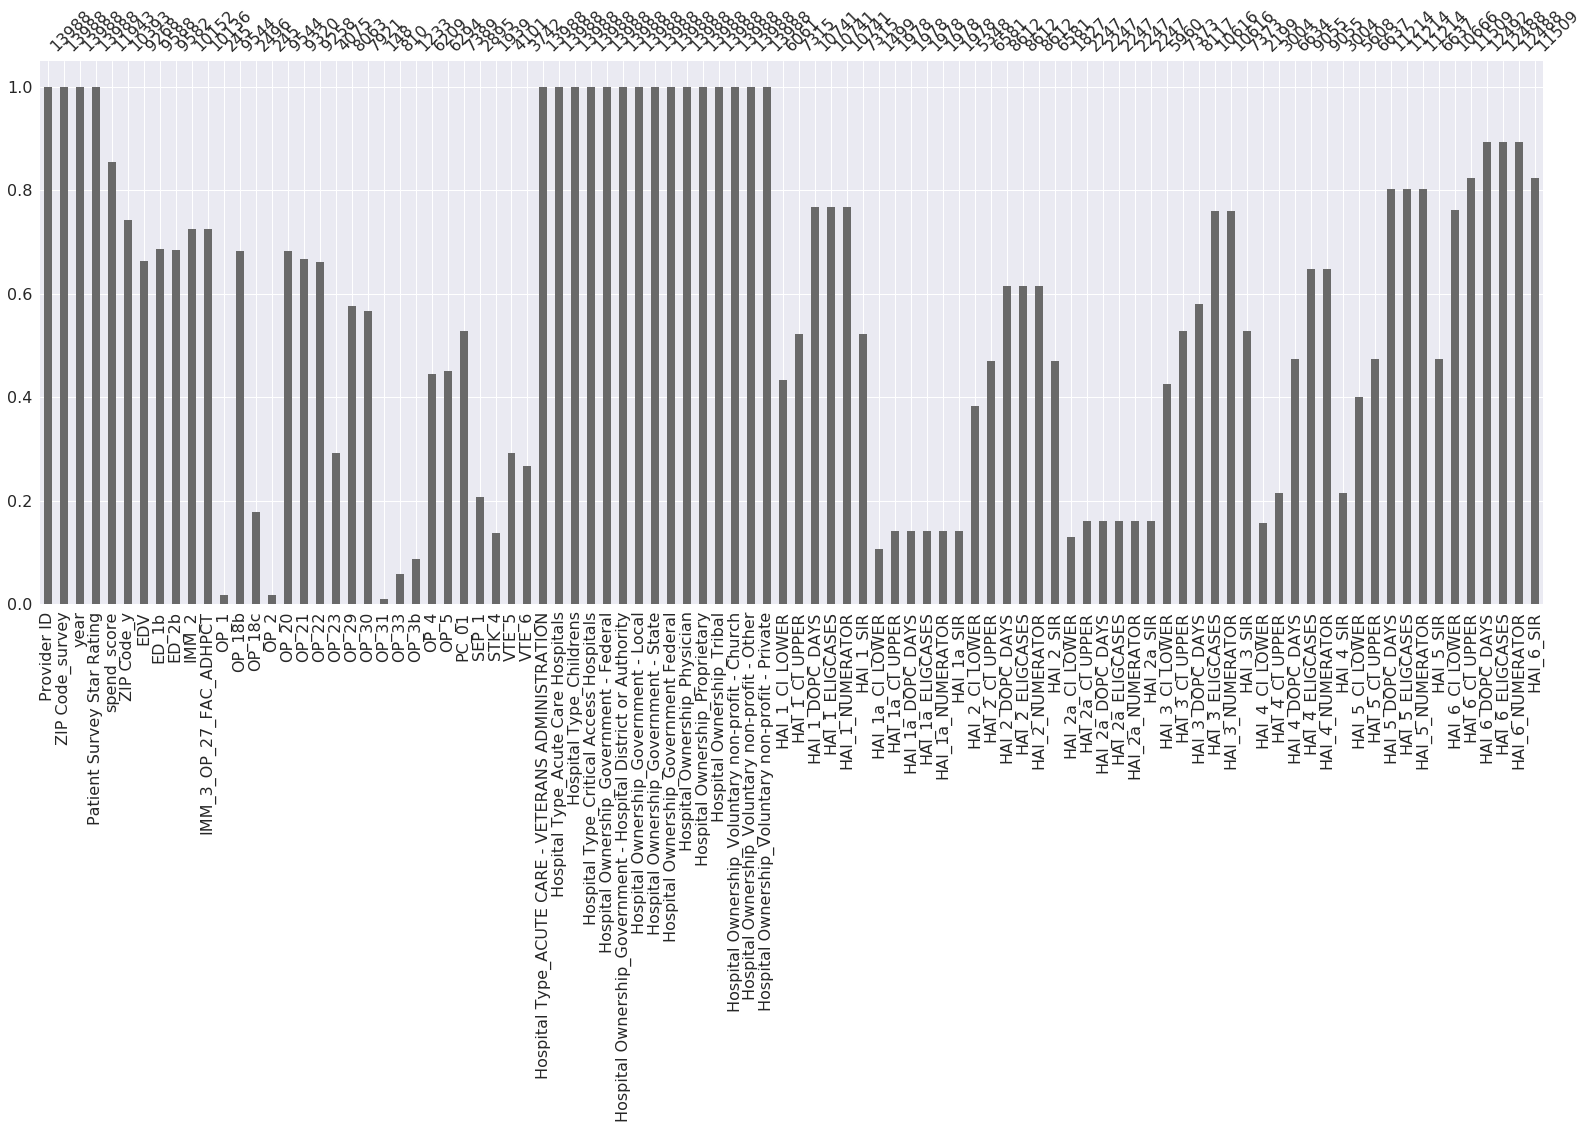

In [73]:
msno.bar(survey_te_hos_infect)

In [99]:
survey_te_hos_infect_zeros = survey_te_hos_infect.fillna(0)

In [100]:
survey_te_hos_infect_zeros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13988 entries, 0 to 13987
Data columns (total 94 columns):
Provider ID                                                       13988 non-null object
ZIP Code_survey                                                   13988 non-null object
year                                                              13988 non-null int64
Patient Survey Star Rating                                        13988 non-null int64
spend_score                                                       13988 non-null float64
ZIP Code_y                                                        13988 non-null object
EDV                                                               13988 non-null float64
ED_1b                                                             13988 non-null float64
ED_2b                                                             13988 non-null float64
IMM_2                                                             13988 non-null float64
IMM_3_OP

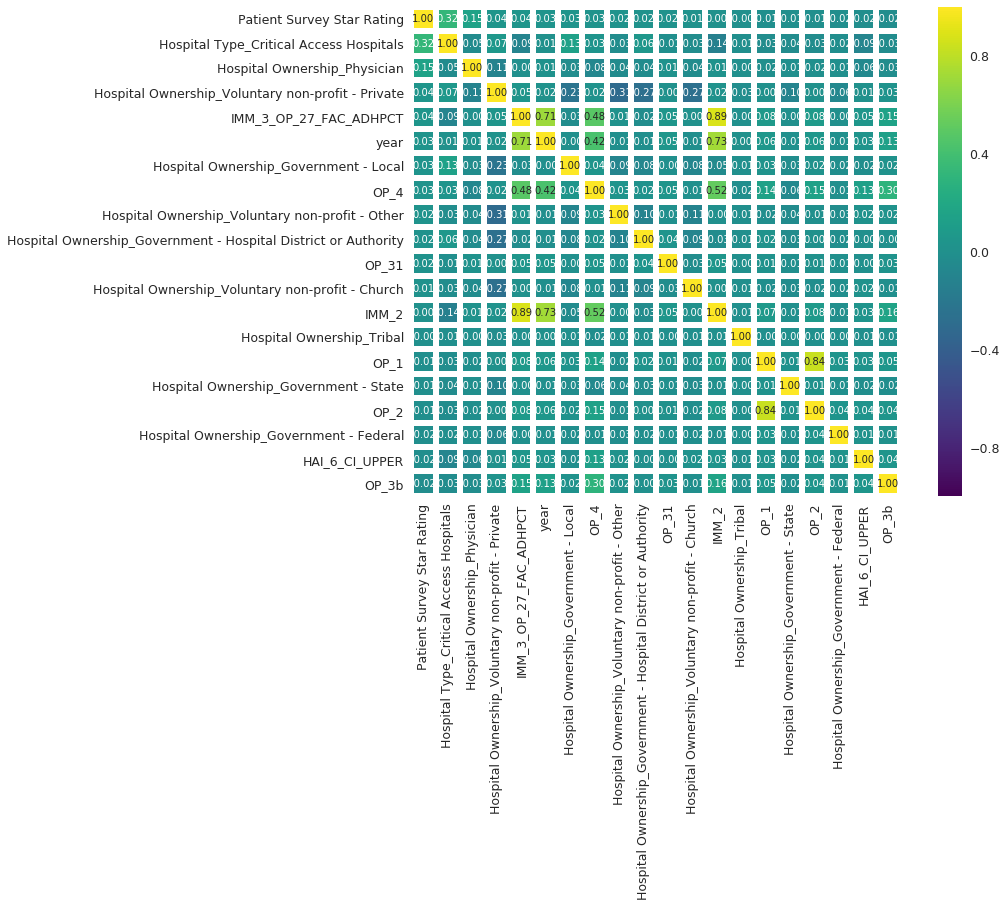

In [101]:
corrlist = survey_te_hos_infect_zeros.corr()

k = 20
cols = corrlist.nlargest(k, 'Patient Survey Star Rating')['Patient Survey Star Rating'].index
cm = np.corrcoef(survey_te_hos_infect_zeros[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, linewidth = 5,
                 yticklabels=cols.values, xticklabels=cols.values, cmap = 'viridis', linecolor = 'white')
plt.show()

In [102]:
logreg = LogisticRegression()
ss = StandardScaler()

X = survey_te_hos_infect_zeros[[
       'spend_score','EDV', 'ED_1b', 'ED_2b', 'IMM_2',
       'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_18c', 'OP_2', 'OP_20',
       'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_31', 'OP_33', 'OP_3b',
       'OP_4', 'OP_5', 'PC_01', 'SEP_1', 'STK_4', 'VTE_5', 'VTE_6',
       'HAI_1_CI_LOWER',
       'HAI_1_CI_UPPER', 'HAI_1_DOPC_DAYS', 'HAI_1_ELIGCASES',
       'HAI_1_NUMERATOR', 'HAI_1_SIR', 'HAI_1a_CI_LOWER', 'HAI_1a_CI_UPPER',
       'HAI_1a_DOPC_DAYS', 'HAI_1a_ELIGCASES', 'HAI_1a_NUMERATOR',
       'HAI_1a_SIR', 'HAI_2_CI_LOWER', 'HAI_2_CI_UPPER', 'HAI_2_DOPC_DAYS',
       'HAI_2_ELIGCASES', 'HAI_2_NUMERATOR', 'HAI_2_SIR', 'HAI_2a_CI_LOWER',
       'HAI_2a_CI_UPPER', 'HAI_2a_DOPC_DAYS', 'HAI_2a_ELIGCASES',
       'HAI_2a_NUMERATOR', 'HAI_2a_SIR', 'HAI_3_CI_LOWER', 'HAI_3_CI_UPPER',
       'HAI_3_DOPC_DAYS', 'HAI_3_ELIGCASES', 'HAI_3_NUMERATOR', 'HAI_3_SIR',
       'HAI_4_CI_LOWER', 'HAI_4_CI_UPPER', 'HAI_4_DOPC_DAYS',
       'HAI_4_ELIGCASES', 'HAI_4_NUMERATOR', 'HAI_4_SIR', 'HAI_5_CI_LOWER',
       'HAI_5_CI_UPPER', 'HAI_5_DOPC_DAYS', 'HAI_5_ELIGCASES',
       'HAI_5_NUMERATOR', 'HAI_5_SIR', 'HAI_6_CI_LOWER', 'HAI_6_CI_UPPER',
       'HAI_6_DOPC_DAYS', 'HAI_6_ELIGCASES', 'HAI_6_NUMERATOR', 'HAI_6_SIR']]
y = survey_te_hos_infect_zeros['Patient Survey Star Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [124]:
from imblearn.over_sampling import SMOTE

In [125]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [127]:
sm = SMOTE()
x_train_res, y_train_res = sm.fit_sample(X_train_scaled, y_train)


(array([4408.,    0., 4408.,    0.,    0., 4408.,    0., 4408.,    0.,
        4408.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

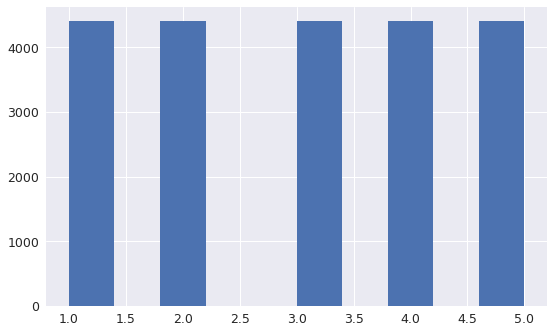

In [132]:
plt.hist(y_train_res)

### Logistic Regression

In [133]:
model = logreg.fit(x_train_res,y_train_res)
print("Train: ",model.score(x_train_res, y_train_res))
print("Test: ", model.score(X_test_scaled, y_test))

Train:  0.5941923774954628
Test:  0.38375750643408635


0.5424649699742636

Text(0.5, 1.0, 'Logistic Regression Coefficients')

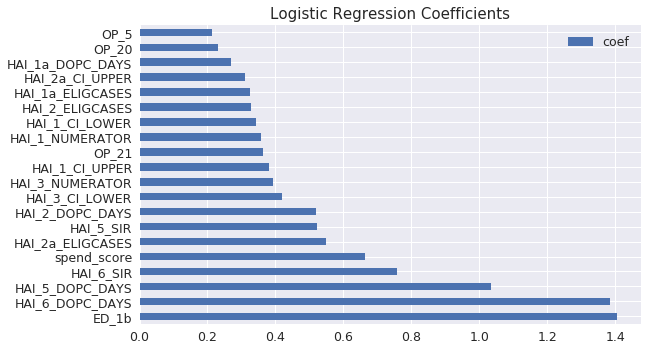

In [106]:
coefs = pd.DataFrame(logreg.coef_[0], index = X.columns, columns = ['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head(20).plot(kind = 'barh')
plt.title('Logistic Regression Coefficients')

### Random Forrest

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators= 100)
rf.fit(x_train_res, y_train_res)

print("Train: ", rf.score(x_train_res, y_train_res))
print("Test: ", rf.score(X_test_scaled, y_test))


Train:  0.9867967332123412
Test:  0.5344581069488132


### Support Vector Classifier

In [135]:
from sklearn.svm import SVC

scv = SVC()

scv.fit(x_train_res, y_train_res)
print("Train: ", scv.score(x_train_res, y_train_res))
print("Test: ", scv.score(X_test_scaled, y_test))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### KNN

In [138]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train_scaled,y_train)

print("Train: ", knn.score(X_train_scaled, y_train))
print("Test: ", knn.score(X_test_scaled, y_test))


Train:  0.6404537222381088
Test:  0.49385187303402917
